In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import os
import cv2
%matplotlib inline

In [3]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
def average_line(lines):
    # takes a list of lines
    # each line: [slope, intercept]
    # returns average slope and intercept
    cnt, slope, intercept = 0,0,0
    for line in lines:
        if line:
            slope += line[0]
            intercept += line[1]
            cnt+=1
    return None if cnt==0 else (slope/cnt, intercept/cnt)

def get_x(y, line):
    # calculates x coord for a given y coord
    slope, intercept = line
    return int((y - intercept) / slope)

def hough_lines(img, ρ, θ, α, min_line_len, max_line_gap,debug=False):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    ------
    Parameters:
    ρ [rho]
    θ [theta]
    α [threshold]
    """
    lines = cv2.HoughLinesP(img, ρ, θ, α, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img,pot_lines = draw_lines_new(line_img, lines,debug=debug)
    for index,line in enumerate(pot_lines):
        if line:
            cv2.line(line_img, (get_x(img.shape[0], line), img.shape[0]), (get_x(0, line), 0), 
            (0,0,255) if index == 0 else (0,255,0), 3)  
    return line_img,pot_lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def get_line_params(line):
    # receives a vector of [x1, y1, x2, y2] and returns a slope, intercept
    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]
    x = [x1, x2]
    y = [y1, y2]
    slope, intercept = np.polyfit(x, y, deg=1)
    return slope, intercept

def get_roi_vertices(image, vert_coef=0.35, hor_up=0.28, hor_down=0):
    '''
    this routine returns 4 vertices of the area in front of the car
    for top-down view perspective warp
    '''
    # finding the best region of interest
    y_size, x_size = image.shape[:2]

    # proportion of vertical size before upper line of ROI starts (starting from top)
    v_coef = vert_coef
    v_down = 0.95
    # proportion of horizontal size before upper right point of ROI (starting from right)
    up_left_coef = hor_up
    # proportion of horizontal size before upper right point of ROI (starting from left)
    up_right_coef = 1 - up_left_coef

    low_left_coef = hor_down
    low_right_coef = 1 - low_left_coef

    # defining tuple of 4 points of ROI
    low_left_point = [x_size * low_left_coef, y_size * v_down]
    low_right_point = [x_size * low_right_coef, y_size * v_down]
    up_left_point = [x_size * up_left_coef, y_size * v_coef]
    up_right_point = [x_size * up_right_coef, y_size * v_coef]

    # defining a poly (first and last points are the same to close the poly)
    verts = np.array( [up_left_point, up_right_point, low_right_point, low_left_point], dtype=np.float32)
    verts = np.reshape(verts, (4,1,2))
    return verts

def plotz(img, cmap='gray'):
    plt.imshow(img, cmap=cmap)
    plt.show()

def corners_unwarp(img, vert_coef=0.35, hor_up=0.28, hor_down=0):
    # def corners_unwarp(img, vert_coef=0.63, hor_coef=0.444):
    '''
    this routine unwarps area in front of car into top-down view
    it returns warped image as well as warm and unwarp matrices
    '''
    # `o` is offset (was used in classroom example)
    off_l = 0.0
    off_r = 1 - off_l
    o = 0
    # grab the image shape
    width = img.shape[0]
    height = img.shape[1]
    src = get_roi_vertices(img, vert_coef, hor_up, hor_down)
    # destination points are corners of output image
    dst = np.float32([[o,width * off_l], [height-o,width * off_l], [height-o,width * off_r], [o,width * off_r]])
    dst = np.reshape(dst, (4,1,2))
    # given src and dst points, calculate the perspective transform matrix and inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (height, width))

    # Return the resulting image and matrix
    return warped, M, Minv

def line_intersection_with_border(line,width,height,debug=False):
    xy = []
    for border in [(0,1,0),(0,1,-height),(1,0,0),(1,0,-width)]:
        x = (1*border[2] - border[1]*-line[1])    //  (-line[0]*border[1]-border[0]*1)
        y = (border[0]*-line[1] + line[0]*border[2])//(-line[0]*border[1]-border[0]*1)
        if 0<=x<=width and 0<=y<=height:
            xy.append((x,y)) 
    return xy

def top_down_view(image,lines,lane=1):
    # zakrepeno malku
    off_l = 0.0
    off_r = 1 - off_l
    o = 0
    # grab the image shape
    width = image.shape[1]
    height = image.shape[0]
    if lane == 'left':
        left_lane = lines[1]
        right_lane = lines[0]
    elif lane == 'right':
        left_lane = lines[0]
        right_lane = lines[2]
    else:
        left_lane = lines[1]
        right_lane = lines[2]
    src  = np.float32([ line_intersection_with_border(left_lane,width,height)[0], 
                        line_intersection_with_border(right_lane,width,height)[0],
                        line_intersection_with_border(right_lane,width,height)[1], 
                        line_intersection_with_border(left_lane,width,height)[1]])
    src = np.reshape(src, (4,1,2))
    # destination points are corners of output image
    dst = np.float32([[o,width * off_l], [height-o,width * off_l], [height-o,width * off_r], [o,width * off_r]])
    dst = np.reshape(dst, (4,1,2))
    # given src and dst points, calculate the perspective transform matrix and inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, (height, width))

    # Return the resulting image and matrix
    return warped, M, Minv
    
def gamma_corection(image,gamma=3):
    ## [changing-contrast-brightness-gamma-correction]
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    return cv2.LUT(image, lookUpTable)

In [4]:
def grouper(iterable,treshold = 30):
    prev = None
    group = []
    for slope,intersection,x_iter in iterable:
        if prev is None or x_iter - prev <= treshold:# moze da se dodae i flterce da se ostranat dalecni slopes
            group.append((slope,intersection))
        else:
            yield group
            group = [(slope,intersection)]
        prev = x_iter
    if group:
        yield group
           
def draw_lines_new(image, lines, color=[0, 255, 0], thickness=3, past = 2, debug=False):
    img = np.copy(image)
    # points for lines
    ysize = img.shape[0]
    xsize = 500
 
    lines_params = []
    for line in lines:
        slope,intersection = get_line_params(line[0])
        if strait_slope_range[0] < abs(slope) < strait_slope_range[1]:
            x_iter = get_x(ysize//2, (slope, intersection))
            lines_params.append([slope,intersection,x_iter])
    if len(lines_params) == 0:
        return img,[None,None,None]
    lines_params  = np.array(lines_params)  
    sorted_lines_params = lines_params[lines_params[:, 2].argsort()]
 
    grouped_lines = [average_line(grouped_lines) for grouped_lines in grouper(sorted_lines_params)]
    group_treshold = 30
    while len(grouped_lines)<2:
        if group_treshold == 5:
            if debug:
                for line in lines: cv2.line(img, (line[0][0], line[0][1]), (line[0][2], line[0][3]), [255,255,0], 2) 
            if len(past_potental_lines[0])>0:
                return img,[average_line(past_potental_lines[0]),average_line(past_potental_lines[1]),average_line(past_potental_lines[2])]
            else:
                return img,[None,None,None]
        grouped_lines = [average_line(grouped_lines) for grouped_lines in grouper(sorted_lines_params,group_treshold)]
        group_treshold -= 5

    if len(past_potental_lines[0]) == past:
        dif_dash,dif_left,dif_right = (0,xsize),(0,xsize),(0,xsize)
        pot_dash,pot_left,pot_right = [None]*3
        past_dash,past_left,past_right = [average_line(past_potental_lines[0]),average_line(past_potental_lines[1]),average_line(past_potental_lines[2])]
        x_grouped_lines = [get_x(ysize//2, grouped_line) for grouped_line in grouped_lines]
        
        for ind,x_grouped_line in enumerate(x_grouped_lines):
            if past_dash and dif_dash[1] > abs(x_grouped_line - get_x(ysize//2, past_dash)):
                dif_dash = (ind, abs(x_grouped_line - get_x(ysize//2, past_dash))) 
            if past_left and dif_left[1] > abs(x_grouped_line - get_x(ysize//2, past_left)):
                dif_left = (ind, abs(x_grouped_line - get_x(ysize//2, past_left))) 
            if past_right and dif_right[1] > abs(x_grouped_line - get_x(ysize//2, past_right)):
                dif_right = (ind, abs(x_grouped_line - get_x(ysize//2, past_right))) 

        pot_dash = grouped_lines[dif_dash[0]] if dif_dash[1] < 40 else past_dash #zasega ako se blisku
        pot_left = grouped_lines[dif_left[0]] if dif_left[1] < 40  else None #ako se stavi noone ke pocne druga da bara
        pot_right = grouped_lines[dif_right[0]] if dif_right[1] < 40 else None
   
        if not past_dash:
            is_dahed_lines = [dash_line_test(th1,grouped_line) for grouped_line in grouped_lines]
            pot_dash = grouped_lines.pop(is_dahed_lines.index(True)) if True in is_dahed_lines else None
     
        if not past_left and past_dash:
            x_dashed_line = get_x(ysize//2, past_dash)
            x_grouped_lines_diff = [get_x(ysize//2, grouped_line) - x_dashed_line for grouped_line in grouped_lines]
            left_line_diff = xsize
            past_x_left_diff = sum([left_diff for left_diff in past_lane_dff[0] if left_diff])
            past_x_left_diff = -40 if past_x_left_diff == 0 else past_x_left_diff/len([left_diff for left_diff in past_lane_dff[0] if left_diff])
            for x_diff in x_grouped_lines_diff:
                if x_diff < past_x_left_diff + 20 and abs(left_line_diff) > abs(x_diff):
                    left_line_diff = x_diff
            if left_line_diff != xsize:        
                pot_left  = grouped_lines.pop(x_grouped_lines_diff.index(left_line_diff))
        
        if not past_right and past_dash:
            x_dashed_line = get_x(ysize//2, past_dash)
            x_grouped_lines_diff = [get_x(ysize//2, grouped_line) - x_dashed_line for grouped_line in grouped_lines]
            right_line_diff = xsize
            past_x_right_diff = sum([right_diff for right_diff in past_lane_dff[0] if right_diff])
            past_x_right_diff = 40 if past_x_right_diff == 0 else past_x_right_diff/len([right_diff for right_diff in past_lane_dff[0] if right_diff])
            for x_diff in x_grouped_lines_diff:
                if x_diff > past_x_right_diff - 20 and right_line_diff > x_diff:
                    right_line_diff = x_diff 
            if right_line_diff != xsize:        
                pot_right  = grouped_lines.pop(x_grouped_lines_diff.index(right_line_diff))
        #final check
        if pot_dash == None  and past_dash == None:
            is_dased_line = False
            is_left_line = is_right_lane =  (get_x(ysize//2, pot_left) < get_x(ysize//2, pot_right)) if pot_left and pot_right else False
            past_lane_dff[0].append(None)
            past_lane_dff[1].append(None)
        else:
            is_dased_line = dash_line_test(th1,pot_dash) if pot_dash else False
            is_left_line = get_x(ysize//2, pot_left)<get_x(ysize//2, pot_dash if is_dased_line else past_dash) if pot_left else False
            is_right_lane = get_x(ysize//2, pot_dash if is_dased_line else past_dash)<get_x(ysize//2,pot_right) if pot_right else False
            # temporal lines
            left_line_diff =  get_x(ysize//2, pot_left)  - get_x(ysize//2, pot_dash if is_dased_line else past_dash) if pot_left else None
            right_line_diff = get_x(ysize//2, pot_right) - get_x(ysize//2, pot_dash if is_dased_line else past_dash) if pot_right else None
            past_lane_dff[0].append(left_line_diff)
            past_lane_dff[1].append(right_line_diff)
       
        past_potental_lines[0].append(pot_dash  if is_dased_line else None)
        past_potental_lines[1].append(pot_left  if is_left_line  else None)
        past_potental_lines[2].append(pot_right if is_right_lane else None)
        
        if len(past_potental_lines[0]) > past:
            past_potental_lines[0].pop(0)
            past_potental_lines[1].pop(0)
            past_potental_lines[2].pop(0)
            past_lane_dff[0].pop(0)
            past_lane_dff[1].pop(0)              
        potental_lines = [pot_dash  if pot_dash else None ,pot_left  if pot_left else None,pot_right  if pot_right else None]
    else:
        # find dashed line if not return nothing
        is_dahed_lines = [dash_line_test(th1,grouped_line) for grouped_line in grouped_lines]
        if True not in is_dahed_lines:
            print('dash err at ', i)
            return img,[None]*3
        dashed_line = grouped_lines.pop(is_dahed_lines.index(True))
        x_dashed_line = get_x(ysize//2, dashed_line)
        x_grouped_lines_diff = [get_x(ysize//2, grouped_line) - x_dashed_line for grouped_line in grouped_lines]
        # find left and right line
        left_line_diff,right_line_diff = xsize,xsize
        left_line,right_line = None,None
        for x_diff in x_grouped_lines_diff:
            if x_diff < 0 and abs(left_line_diff) > abs(x_diff):
                left_line_diff = x_diff
            elif x_diff > 0 and right_line_diff > x_diff:
                right_line_diff = x_diff 
        if left_line_diff != xsize:        
            left_line  = grouped_lines.pop(x_grouped_lines_diff.index(left_line_diff))
            x_grouped_lines_diff.pop(x_grouped_lines_diff.index(left_line_diff))
        if right_line_diff != xsize:   
            right_line = grouped_lines.pop(x_grouped_lines_diff.index(right_line_diff))
            x_grouped_lines_diff.pop(x_grouped_lines_diff.index(right_line_diff))    
        # temporal lines append prev for the begining
        past_lane_dff[0].append(left_line_diff if left_line else None)
        past_lane_dff[1].append(right_line_diff if right_line else None)
        past_potental_lines[0].append(dashed_line if dashed_line else past_potental_lines[0][-1])
        past_potental_lines[1].append(left_line if left_line else (past_potental_lines[1][-1] if past_potental_lines[1]  else None))
        past_potental_lines[2].append(right_line if right_line else (past_potental_lines[2][-1] if past_potental_lines[2] else None))
        if len(past_potental_lines[0]) > past:
            past_potental_lines[0].pop(0)
            past_potental_lines[1].pop(0)
            past_potental_lines[2].pop(0)
            past_lane_dff[0].pop(0)
            past_lane_dff[1].pop(0)       
        potental_lines = [average_line(past_potental_lines[0]),average_line(past_potental_lines[1]),average_line(past_potental_lines[2])]
    if debug:
        for group_line in grouped_lines:
            cv2.line(img, (get_x(ysize, group_line), ysize), (get_x(0, group_line), 0), (255,0,0), thickness)  
        for line in lines:
            cv2.line(img, (line[0][0], line[0][1]), (line[0][2], line[0][3]), 
            [255,255,0] if 0.3 < abs(get_line_params(line[0])[0]) < 3 else [255,0,255], 2) 
    
    return img,potental_lines

In [5]:
def dash_line_test(image, line, step=2, treshold=3, ofset=20, debug=False):
    colors = []
    line_filter = 0
    dir = None # True is up
    for y_test in range(image.shape[0]-step,step,-step):
        x_test = get_x(y_test, line)
        if  x_test < 0 or image.shape[1] < x_test:
            continue
        current_color = image[y_test-step//2:y_test+step//2,x_test-treshold:x_test+treshold].mean()
        if debug:
            print(y_test, current_color)
        if not colors: 
            colors.append((y_test,current_color))
            dir = current_color > 170
            continue
        line_filter +=1
        if abs(colors[-1][1] - current_color) > 130:
            if dir == (colors[-1][1] - current_color > 0) and line_filter > 2:
                colors.append((y_test,current_color))
                line_filter = 0
                dir = not dir
    cnt_gray = 0
    for y_test,color in colors:
        adj_left_color =  image[y_test-treshold:y_test+treshold,x_test-ofset-treshold:x_test-ofset+treshold].mean()
        adj_right_color =  image[y_test-treshold:y_test+treshold,x_test+ofset-treshold:x_test+ofset+treshold].mean()
        if adj_left_color < 100 and  adj_right_color < 100:
            cnt_gray+=1
    if debug:
        print(colors)
    return len(colors) > 2 and  cnt_gray >= len(colors)//2 
    
def draw_car_direction(image,color=[0,255,255],thickness=2):
    img = np.copy(image)
    ysize = img.shape[0]
    xsize = img.shape[1]
    cv2.line(img, (xsize//2, 0), (xsize//2, ysize), color, thickness)
    return img

In [6]:
DIM=(410, 308)
K=np.array([[171.0979583888746, 0.0, 203.832157593343], [0.0, 169.87861660728842, 152.47239113949564], [0.0, 0.0, 1.0]])
D=np.array([[-0.008369503627831692], [-0.07768839820625655], [0.10177033308737245], [-0.04056049534190911]])

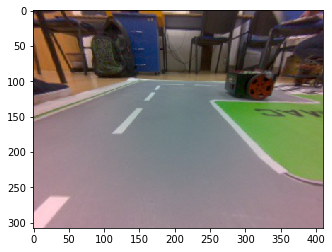

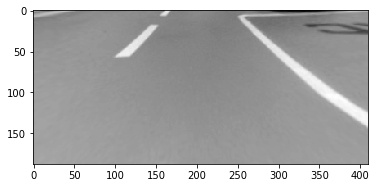

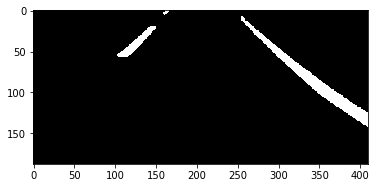

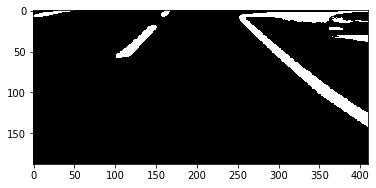

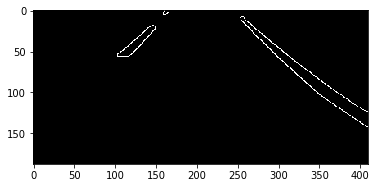

c:\Users\vase_\miniconda3\envs\mv\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
c:\Users\vase_\miniconda3\envs\mv\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[(0.8213267335798062, -192.6726435982618), (-0.9169398117126242, 152.93017512799682), None]


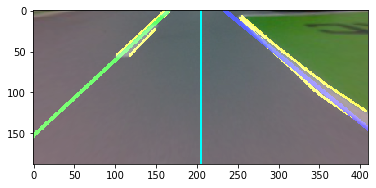

TypeError: 'NoneType' object is not subscriptable

In [14]:
# applying pipeline to test images and saving them
past_potental_lines = [[],[],[]]  
past_lane_dff = [[],[]] 
strait_slope_range = (0.3,3) 
im_path = r'C:\Users\vase_\Downloads\jetbot-nano\Data\snapshots\test/'
im_name = '510.jpg'
test_img = mpimg.imread(f"{im_path}/{im_name}")
plotz(test_img)
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
undistorted_img = cv2.remap(test_img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)[120:,:]
#plotz(undistorted_img)
plt.imsave(os.path.join(im_path, "step0.jpg") , undistorted_img)
verts = get_roi_vertices(undistorted_img)
t = 50
# convert to grayscale
gray_img =grayscale(undistorted_img)
plotz(gray_img)
plt.imsave(os.path.join(im_path, "step1.jpg") , gray_img, cmap='gray')
# apply blur
blurred_img = cv2.medianBlur(gray_img,5)
#plotz(blurred_img)
plt.imsave(os.path.join(im_path, "step2.jpg") , blurred_img, cmap='gray')
# top down vuie bipass
binary, warp_mtx, unwarp_mtx = corners_unwarp(blurred_img)
#plotz(binary)
plt.imsave(os.path.join(im_path, "step3.jpg") , binary, cmap='gray')
# treshold
thresh1 = cv2.adaptiveThreshold(blurred_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,55,-6)
ret,th1 = cv2.threshold(blurred_img,170,255,cv2.THRESH_BINARY)
plotz(th1)
plotz(thresh1)
# canny image on top of blur
canny_img = canny(th1, t, t*2)
plotz(canny_img)
plt.imsave(os.path.join(im_path, "step4.jpg") , canny_img, cmap='gray')
# apply ROI mask to canny
#masked_canny = region_of_interest(canny_img, verts)
#plotz(masked_canny)
#plt.imsave(os.path.join(im_path, "step5.jpg") , masked_canny, cmap='gray')
# get lines for canny
lines_canny_img,pot_lines = hough_lines(canny_img, 3, np.pi/180, 50, 10, 50,True)#50 so 100
print(pot_lines)
# get final image
final_img = draw_car_direction(weighted_img(lines_canny_img, undistorted_img))
plotz(final_img)
topdown,M,Minv = top_down_view(final_img,pot_lines,'sho')
plotz(topdown)
plt.imsave(os.path.join(im_path, "step6.jpg") , final_img)

In [16]:
past_potental_lines = [[],[],[]]  
past_lane_dff = [[],[]]  
strait_slope_range = (0.3,3)
im_path = r'C:\Users\vase_\Downloads\jetbot-nano\Data\vid8/'
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
for i in range(200):
    test_img = mpimg.imread(im_path+ str(i)+'.jpg')
    undistorted_img = cv2.remap(test_img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)[120:,:]
    gray_img = grayscale(undistorted_img)
    blurred_img = gaussian_blur(gray_img, 5)
    _,th1 = cv2.threshold(blurred_img,170,255,cv2.THRESH_BINARY)
    t = 60
    canny_img = canny(th1, t, t*2)
    #print(i,end=' ')
    lines_canny_img,pot_lines = hough_lines(canny_img, 3, np.pi/180, 50, 10, 50,debug=True)
    final_img = draw_car_direction(weighted_img(lines_canny_img, undistorted_img))
    #topdown,M,Minv = top_down_view(undistorted_img,pot_lines,'left')
    plt.imsave(im_path+'out/'+str(i)+'.jpg', final_img)

c:\Users\vase_\miniconda3\envs\mv\lib\site-packages\ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned
c:\Users\vase_\miniconda3\envs\mv\lib\site-packages\ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned


In [9]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [15]:
img_array = []
file_path = r'C:\Users\vase_\Downloads\jetbot-nano\Machine Vision\yolo\yolov5\runs\detect\exp3/'
for i in sorted_alphanumeric(os.listdir(file_path)):
    img = cv2.imread(file_path+i)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

In [16]:
out = cv2.VideoWriter('project1.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()